In [4]:
#import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
import jax
import juniper as jp

from juniper.Gaussian import Gaussian
from juniper.LateralKernel import LateralKernel

from juniper.steps.NeuralField import NeuralField
from juniper.steps.StaticGain import StaticGain
from juniper.steps.DemoInput import DemoInput
from juniper.steps.TimedBoost import TimedBoost
from juniper.steps.Projection import Projection
from juniper.steps.Sum import Sum


from demo.demo_corsi_sequence import demo_corsi_sequence

In [5]:
print("Computing devices found by JAX:")
print(jax.local_devices())

Computing devices found by JAX:
[CpuDevice(id=0)]


In [6]:
arch = jp.Architecture.get_arch()

<img src="demo/img/corsi_sequence.drawio.png" alt="drawing" width="600"/>

In [7]:
jp.Architecture.delete_arch()
arch = jp.Architecture.get_arch()
shape = (294, 447)
modes = ['mem', 'repr']  # to create copies of ordinal machinery
gains = {}
nodes = {}


### Static steps
# input and attention, transient detector
boost_memorize = TimedBoost("boost_mem", {"amplitude":4, "duration": [0, 3]}) # 150 steps * 0.02msec
boost_query = TimedBoost("boost_reproduce", {"amplitude":3, "duration": [3.2, 8]})
demo_inputs = [DemoInput("in"+str(i), {"shape":shape, "sigma":(8,8), "amplitude":0, "center": (0,0)}) for i in range(4)]
proj0 = Projection("proj0", {"input_shape":shape, "output_shape":(1,), "axis":(0,1), "order":(), "compression_type": "Maximum"})                   
st6 = StaticGain("st6", {"factor": 6})
st4 = StaticGain("st4", {"factor": -6})
# mental maps
st0 = StaticGain("st0", {"factor": 3})
st2s = []
[st2s.append(StaticGain(f"st2_{i}", {"factor": 3})) for i in range(4)] 
# int and cos
gains[f"mem_proj61"] = Sum("mem_proj61", {})
gains[f"repr_proj61"] = Projection("repr_proj61", {"input_shape":shape, "output_shape":(1,), "axis":(0,1), "order":(), "compression_type": "Maximum"})                   
for mode in modes:
    gains[f"{mode}_st3"] = StaticGain(f"{mode}_st3", {"factor": 3})
    gains[f"{mode}_st5"] = StaticGain(f"{mode}_st5", {"factor": 3})
    gains[f"{mode}_st8"] = StaticGain(f"{mode}_st8", {"factor": -20})
    gains[f"{mode}_st7"] = StaticGain(f"{mode}_st7", {"factor": 3})
# cos detector (shared, not mode-specific here)
st65s = [StaticGain(f"st65_{i}", {"factor": 2}) for i in range(4)]
proj110s = [Projection(f"proj110_{i}", {"input_shape": shape, "output_shape": (1,), "axis": (0,1), "order": (), "compression_type": "Maximum"}) for i in range(4)]
st99s = [StaticGain(f"st99_{i}", {"factor": 4}) for i in range(4)]
# ordinal machinery
for mode in modes:
    gains[f"{mode}_st_cos_ord"] = StaticGain(f"{mode}_st_cos_ord", {"factor": -30})
    gains[f"{mode}_st131"] = StaticGain(f"{mode}_st131", {"factor": 10})
    gains[f"{mode}_st45"] = StaticGain(f"{mode}_st45", {"factor": 15})
    gains[f"{mode}_start_bias"] = TimedBoost(f"{mode}_biasordinal", {"amplitude": 1, "duration": [0, 99]})
    for i in range(4):
        gains[f"{mode}_stmo{i}{i}"] = StaticGain(f"{mode}_stm{i}o{i}", {"factor": -5})
        gains[f"{mode}_stom{i}{i}"] = StaticGain(f"{mode}_sto{i}m{i}", {"factor": 10})
        gains[f"{mode}_latio{i}"] = StaticGain(f"{mode}_latio{i}", {"factor": -20})
    for i in range(3):
        gains[f"{mode}_stmo{i}{i+1}"] = StaticGain(f"{mode}_stm{i}o{i+1}", {"factor": 10})
# sequence reproduction
st9s = []
[st9s.append(StaticGain(f"st9_{i}", {"factor": 3})) for i in range(4)] 
proj2 = Sum("proj2", {})
st13 = StaticGain("st13", {"factor": 10})
st14 = StaticGain("st14", {"factor": 4})
st30 = StaticGain("st30", {"factor": 4})
st31 = StaticGain("st31", {"factor": 3})
st29s = []
[st29s.append(StaticGain(f"st29_{i}", {"factor": 4})) for i in range(4)]



### field params
att_exc_kernel = Gaussian({"sigma": (7,7), "amplitude": 6, "normalized": True})
node_exc_kernel = Gaussian({"sigma": (0.01,), "amplitude": 1, "normalized": True})
node_ord_kernel = Gaussian({"sigma": (0.01,), "amplitude": 2, "normalized": True})
node_mem_kernel = Gaussian({"sigma": (0.01,), "amplitude": 10, "normalized": True})
mem_exc_kernel = Gaussian({"sigma": (4,4), "amplitude": 200, "normalized": True})
mem_inh_kernel = Gaussian({"sigma": (7,7), "amplitude": -192, "normalized": True})
mem_kernel = LateralKernel({"kernels": [mem_exc_kernel, mem_inh_kernel]})

### Dynamic steps
# attention field and transient detector
field_atn = NeuralField(f"nf_atn", {"shape": shape, "resting_level": -5, "global_inhibition": -0.01, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": att_exc_kernel})
transient_u = NeuralField(f"u", {"shape": (1,), "resting_level": -5, "global_inhibition": 0.0, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": node_exc_kernel})
transient_v = NeuralField(f"v", {"shape": (1,), "resting_level": -5, "global_inhibition": 0.0, "tau": 0.3, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": node_exc_kernel})  # slow time scale
# mental maps
field_maps = []
[field_maps.append(NeuralField(f"map{i}", {"shape": shape, "resting_level": -5, "global_inhibition": -0.01, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": mem_kernel})) for i in range(4)]
# ordinal machinery
for mode in modes:
    for i in range(4):
        nodes[f"{mode}_ord{i}"] = NeuralField(f"{mode}_ord{i}", {"shape": (1,), "resting_level": -20, "global_inhibition": 0.0, "tau": 0.05, "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta": 0, "lateral_kernel_convolution": node_exc_kernel})
        nodes[f"{mode}_mem{i}"] = NeuralField(f"{mode}_mem{i}", {"shape": (1,), "resting_level": -1, "global_inhibition": 0.0, "tau": 0.05, "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta": 0, "lateral_kernel_convolution": node_ord_kernel})
    nodes[f"{mode}_int"] = NeuralField(f"{mode}_int", {"shape": (1,), "resting_level": -5, "global_inhibition": 0.0, "tau": 0.05, "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta": 0, "lateral_kernel_convolution": node_mem_kernel})
    nodes[f"{mode}_cos"] = NeuralField(f"{mode}_cos", {"shape": (1,), "resting_level": -5, "global_inhibition": 0.0, "tau": 0.05, "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta": 0, "lateral_kernel_convolution": node_exc_kernel})


# cos detection field
cos_detectors = []
[cos_detectors.append(NeuralField(f"cosfield{i}", {"shape": (1,), "resting_level": -5, "global_inhibition": 0.0, "tau": 0.06, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": node_exc_kernel})) for i in range(4)]
# reproduction execution
field_readouts = []
[field_readouts.append(NeuralField(f"readout{i}", {"shape": shape, "resting_level": -5, "global_inhibition": -0.01, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": att_exc_kernel})) for i in range(4)]
field_hand = NeuralField(f"nf1", {"shape": shape, "resting_level": -5, "global_inhibition": -0.01, "tau": 0.1, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": att_exc_kernel})
field_hand_cos = NeuralField(f"nfcos", {"shape": shape, "resting_level": -5, "global_inhibition": -0.01, "tau": 0.1, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": att_exc_kernel})


### connections
# input, attention and transient detection
[demo_inputs[i] >> field_atn for i in range(4)]
field_atn >> proj0
proj0 >> st6
st6 >> transient_u
st6 >> transient_v
transient_v >> st4
st4 >> transient_u
# memorize int and cos
boost_memorize >> nodes["mem_int"]
transient_u >> gains[f"mem_st3"]
gains[f"mem_st3"] >> nodes[f"mem_int"]
[cos_detectors[i] >> gains[f"mem_proj61"] for i in range(4)]
gains[f"mem_proj61"] >> gains[f"mem_st5"]
gains[f"mem_st5"] >> nodes[f"mem_cos"]
# cos detectors
[nodes[f"mem_ord{i}"] >> st65s[i] for i in range(4)]
[st65s[i] >> cos_detectors[i] for i in range(4)]
[field_maps[i] >> proj110s[i] for i in range(4)]
[proj110s[i] >> st99s[i] for i in range(4)]
[st99s[i] >> cos_detectors[i] for i in range(4)]
# mental map
[nodes[f"mem_ord{i}"] >> st2s[i] for i in range(4)]
[st2s[i] >> field_maps[i] for i in range(4)]
field_atn >> st0
[st0 >> field_maps[i] for i in range(4)]
# readout and execution
[field_maps[i] >> st9s[i] for i in range(4)]
[st9s[i] >> field_readouts[i] for i in range(4)]
[field_readouts[i] >> proj2 for i in range(4)]
proj2 >> st13
st13 >> field_atn
field_atn >> st14
st14 >> field_hand
boost_query >> field_hand
# additional stuff for sequence reproudction
field_hand >> st30
st30 >> field_hand_cos
proj2 >> st31
st31 >> field_hand_cos
field_hand_cos >> gains['repr_proj61'] 
gains['repr_proj61'] >> gains['repr_st5']
gains['repr_st5'] >> nodes['repr_cos']
boost_query >> gains['repr_st3']
gains['repr_st3'] >> nodes['repr_int']
[nodes[f'repr_ord{i}'] >> st29s[i] for i in range(4)]
[st29s[i] >> field_readouts[i] for i in range(4)]
###############################################
# copies of ordinal machineries
for mode in modes:
    # int and cos
    nodes[f"{mode}_int"] >> gains[f"{mode}_st7"]
    gains[f"{mode}_st7"] >> nodes[f"{mode}_cos"]
    nodes[f"{mode}_cos"] >> gains[f"{mode}_st8"]
    gains[f"{mode}_st8"] >> nodes[f"{mode}_int"]
    # ordinal machine
    nodes[f"{mode}_cos"] >> gains[f"{mode}_st_cos_ord"]
    [gains[f"{mode}_st_cos_ord"] >> nodes[f"{mode}_ord{i}"] for i in range(4)]
    gains[f"{mode}_start_bias"] >> gains[f"{mode}_st131"]
    gains[f"{mode}_st131"] >> nodes[f"{mode}_ord0"]
    nodes[f"{mode}_int"] >> gains[f"{mode}_st45"]
    [gains[f"{mode}_st45"] >> nodes[f"{mode}_ord{i}"] for i in range(4)]
    [nodes[f"{mode}_mem{i}"] >> gains[f"{mode}_stmo{i}{i}"] for i in range(4)]
    [gains[f"{mode}_stmo{i}{i}"] >> nodes[f"{mode}_ord{i}"] for i in range(4)]
    [nodes[f"{mode}_ord{i}"] >> gains[f"{mode}_stom{i}{i}"] for i in range(4)]
    [gains[f"{mode}_stom{i}{i}"] >> nodes[f"{mode}_mem{i}"] for i in range(4)]
    [nodes[f"{mode}_mem{i}"] >> gains[f"{mode}_stmo{i}{i+1}"] for i in range(3)]
    [gains[f"{mode}_stmo{i}{i+1}"] >> nodes[f"{mode}_ord{i+1}"] for i in range(3)]
    [nodes[f"{mode}_ord{i}"] >> gains[f"{mode}_latio{i}"] for i in range(4)]
    [gains[f"{mode}_latio{i}"] >> nodes[f"{mode}_ord{j}"] for i in range(4) for j in range(4) if j != i]
    
arch.compile()

Loading saved buffers...


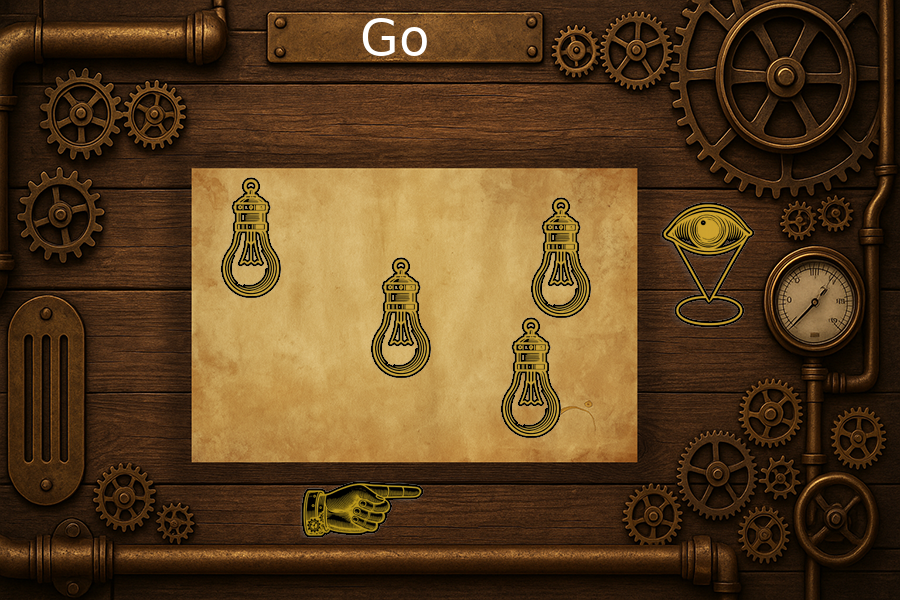

In [8]:
num_steps = 370
demo = demo_corsi_sequence(arch, eye_field="nf_atn", hand_field="nf1")
recording = demo.run(num_steps)

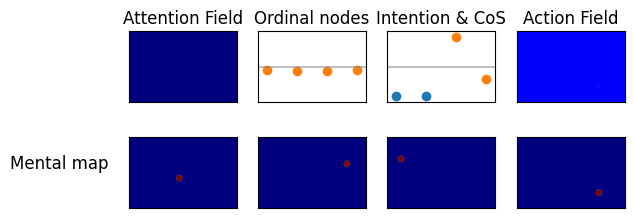

In [9]:
demo.plot()